In [6]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

## TV ADMM Solver (denoising)

### Solve total variation minimization via ADMM

Solves the following problem via ADMM:

```
   min  (1/2)||x - b||_2^2 + lambda * sum_i |x_{i+1} - x_i|
```

where b in R^n.

The solution is returned in the vector x.

history is a structure that contains the objective value, the primal and
dual residual norms, and the tolerances for the primal and dual residual
norms at each iteration.

rho is the augmented Lagrangian parameter.

alpha is the over-relaxation parameter (typical values for alpha are
between 1.0 and 1.8).

More information can be found in the paper linked at:
http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html

*Code adapted from Steven Boyd*
https://web.stanford.edu/~boyd/papers/admm/total_variation/total_variation.html

In [46]:
def quadratic_smoothing(b, lam, rho, alpha):
    MAX_ITER = 1000
    ABSTOL = 1e-4
    RELTOL = 1e-2
    
    n = len(b)
    
    if np.ndim(b) == 1:
        b = b[:, None]
    
    e = np.ones(n)
    
    # difference matrix
    # sparse version
    D = scipy.sparse.spdiags(np.vstack((e, -e)), (0, 1), n, n)
    DtD = D.T @ D
    
    # sparse identity matrix
    I = scipy.sparse.eye(n, format='csc')
    
    # cached factorization
    Fxinv = scipy.sparse.linalg.inv(I + rho * DtD)
    Fzinv = scipy.sparse.linalg.inv(2 * lam * I + rho * I)


    x = np.zeros((n, 1))
    z = x.copy()
    u = x.copy()
    
    history = {'objval' : [],
               'r_norm': [],
               's_norm': [],
               'eps_prim': [],
               'eps_dual': []}
    
    for k in range(MAX_ITER):
        
        # x-update (minimization)
        # uses a direct method
        x = Fxinv @ (b + rho * D.T @ (z - u))
        
        # z-update (minimization) with relaxation
        # also uses a direct method
        z_ = z
        Ax_hat = alpha * D @ x + (1 - alpha) * z_
        z = Fzinv @ (rho * -1 * (-D @ x - u))
        
        # y-update (dual update)
        u = u + Ax_hat - z
        
        # keep track of progress
        objval = objective(b, lam, x, z)
        
        r_norm = np.linalg.norm(D @ x - z)
        s_norm = np.linalg.norm(-rho * D.T @ (z - z_))
        
        eps_prim = np.sqrt(n) * ABSTOL + RELTOL * max(np.linalg.norm(D @ x), np.linalg.norm(-z))
        eps_dual = np.sqrt(n) * ABSTOL + RELTOL * np.linalg.norm(rho * D.T @ u)
        
        history['objval'].append(objval)
        history['r_norm'].append(r_norm)
        history['s_norm'].append(s_norm)
        history['eps_prim'].append(eps_prim)
        history['eps_dual'].append(eps_dual)
        
        if r_norm < eps_prim and s_norm < eps_dual:
            break
        
    return history, x
        
def quad_objective(b, lam, x, z):
    return 0.5 * np.linalg.norm(x - b)**2 + lam * np.linalg.norm(z)**2

def shrinkage(a, kappa):
    return np.clip(a-kappa, a_min=0, a_max=None) - np.clip(-a-kappa, a_min=0, a_max=None)

In [16]:
from scipy.sparse.linalg import LinearOperator, cg

def matrix_free_tv(b, lam, rho, alpha):
    """ Solve total variation minimization via ADMM *without forming the difference matrices*

    Solves the following problem via ADMM:

       min  (1/2)||x - b||_2^2 + lambda * sum_i |x_{i+1} - x_i|

    where b in R^n.

    The solution is returned in the vector x.

    history is a structure that contains the objective value, the primal and
    dual residual norms, and the tolerances for the primal and dual residual
    norms at each iteration.

    rho is the augmented Lagrangian parameter.

    alpha is the over-relaxation parameter (typical values for alpha are
    between 1.0 and 1.8).

    More information can be found in the paper linked at:
    http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html

    *Code adapted from Steven Boyd*
    https://web.stanford.edu/~boyd/papers/admm/total_variation/total_variation.html"""
    MAX_ITER = 1000
    ABSTOL = 1e-4
    RELTOL = 1e-2

    n = len(b)

    def D(v):
        return v - np.roll(v, -1)

    def Dt(v):
        return v - np.roll(v, 1)

    def mv(v):
        # return v + rho * (2*v - np.roll(v, -1) - np.roll(v, 1))
        # return v + rho * DtD @ v
        return v + rho * Dt(D(v))

    F = LinearOperator((n,n), matvec=mv, rmatvec=mv)

    x = np.zeros((n,))
    z = x.copy()
    u = x.copy()

    history = {'objval' : [],
               'r_norm': [],
               's_norm': [],
               'eps_prim': [],
               'eps_dual': []}

    for k in range(MAX_ITER):

        # x-update (minimization)
        # iterative version
        x, _ = cg(F, b + rho * Dt(z - u), maxiter=100, x0 = x)

        # z-update (minimization) with relaxation
        # uses soft thresholding - the proximity operator of the l-1 norm
        z_ = z
        Ax_hat = alpha * D(x) + (1 - alpha) * z_
        z = shrinkage(Ax_hat + u, lam / rho)

        # y-update (dual update)
        u = u + Ax_hat - z

        # keep track of progress
        objval = objective(b, lam, x, z)

        r_norm = np.linalg.norm(D(x) - z)
        s_norm = np.linalg.norm(-rho * z - z_ - np.roll(z - z_, 1))

        eps_prim = np.sqrt(n) * ABSTOL + RELTOL * max(np.linalg.norm(D(x)),
                                                      np.linalg.norm(-z))
        eps_dual = np.sqrt(n) * ABSTOL + RELTOL * np.linalg.norm(rho * Dt(u))

        history['objval'].append(objval)
        history['r_norm'].append(r_norm)
        history['s_norm'].append(s_norm)
        history['eps_prim'].append(eps_prim)
        history['eps_dual'].append(eps_dual)

        if r_norm < eps_prim and s_norm < eps_dual:
            break

    return history, x

In [12]:
from scipy.sparse.linalg import LinearOperator, cg

def matrix_free_tv(b, lam, rho, alpha):
    MAX_ITER = 1000
    ABSTOL = 1e-4
    RELTOL = 1e-2
    
    n = len(b)
    
    def mv(v):
        return v + rho * (2*v - np.roll(v, -1) - np.roll(v, 1))
        # return v + rho * DtD @ v

    F = LinearOperator((n,n), matvec=mv, rmatvec=mv)
    
    x = np.zeros((n,))
    z = x.copy()
    u = x.copy()
    
    history = {'objval' : [],
               'r_norm': [],
               's_norm': [],
               'eps_prim': [],
               'eps_dual': []}
    
    for k in range(MAX_ITER):
        
        # x-update (minimization)
        # iterative version
        x, _ = cg(F, (b + rho * (z - u - np.roll(z - u, 1))), maxiter=10)
        
        # z-update (minimization) with relaxation
        # uses soft thresholding - the proximity operator of the l-1 norm
        z_ = z
        Ax_hat = alpha * (x - np.roll(x, -1)) + (1 - alpha) * z_
        z = shrinkage(Ax_hat + u, lam / rho)
        
        # y-update (dual update)
        u = u + Ax_hat - z
        
        # keep track of progress
        objval = objective(b, lam, x, z)
        
        r_norm = np.linalg.norm(x - np.roll(x, -1) - z)
        s_norm = np.linalg.norm(-rho * z - z_ - np.roll(z - z_, 1))
        
        eps_prim = np.sqrt(n) * ABSTOL + RELTOL * max(np.linalg.norm(x - np.roll(x, -1)), np.linalg.norm(-z))
        eps_dual = np.sqrt(n) * ABSTOL + RELTOL * np.linalg.norm(rho * u - np.roll(u, 1))
        
        history['objval'].append(objval)
        history['r_norm'].append(r_norm)
        history['s_norm'].append(s_norm)
        history['eps_prim'].append(eps_prim)
        history['eps_dual'].append(eps_dual)
        
        if r_norm < eps_prim and s_norm < eps_dual:
            break
        
    return history, x

In [72]:
# generate some noisy data
n = 2000
noise_level = 0.05

b = np.sin(np.linspace(0, np.pi * 2, n))
for i in range(0, n - n//10, n//5):
    b[range(i, i + n//10)] *= 0
b_ = noise_level * np.random.randn(n) + b

CPU times: user 1.68 s, sys: 73.4 ms, total: 1.75 s
Wall time: 1.75 s
CPU times: user 1.62 s, sys: 60.9 ms, total: 1.68 s
Wall time: 1.68 s
CPU times: user 1.59 s, sys: 61.9 ms, total: 1.65 s
Wall time: 1.66 s
CPU times: user 2.02 s, sys: 62.1 ms, total: 2.08 s
Wall time: 2.08 s


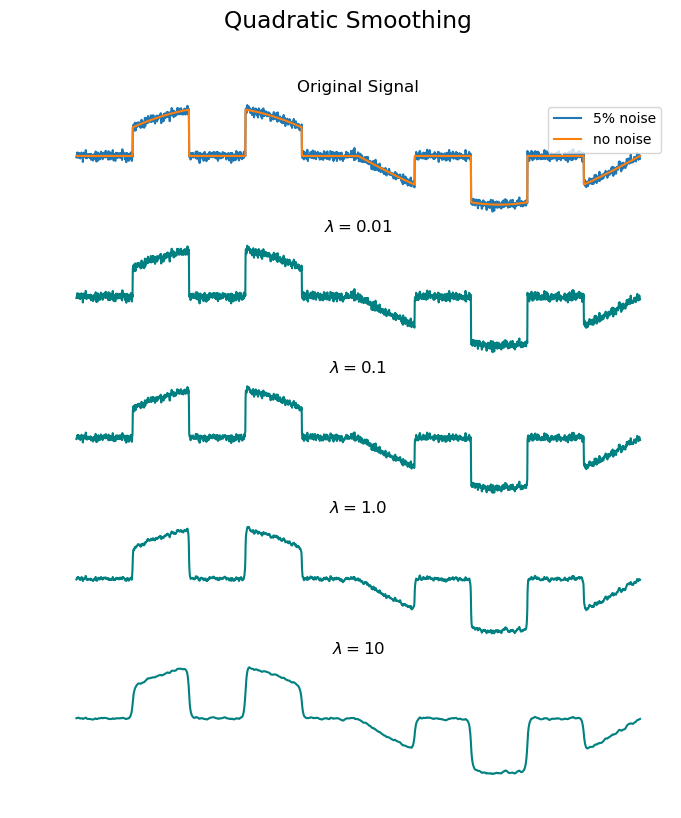

In [104]:
fig, axs = plt.subplots(5, 1, figsize=(8, 9))
fig.suptitle("Quadratic Smoothing")
axs[0].plot(b_, label='5% noise')
axs[0].plot(b, label='no noise')
axs[0].legend(loc='upper right', prop={'size': 10})
axs[0].axis('off')
axs[0].set_title('Original Signal', size=12)

for i, lam in enumerate([0.01, 0.1, 1.0, 10]):
    %time hist, x = quadratic_smoothing(b_, lam, 1.0, 1.0)
    axs[i+1].plot(x, 'teal', label=f'$\lambda = {lam}$')
    axs[i+1].set_title(f'$\lambda = {lam}$', size=12)
    axs[i+1].axis('off')

fig.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/quadratic_smoothing.png", bbox_inches='tight', transparent=True)

CPU times: user 1.11 s, sys: 85.3 ms, total: 1.2 s
Wall time: 1.2 s
CPU times: user 1.14 s, sys: 41.2 ms, total: 1.19 s
Wall time: 1.19 s
CPU times: user 4.15 s, sys: 46.6 ms, total: 4.19 s
Wall time: 4.2 s


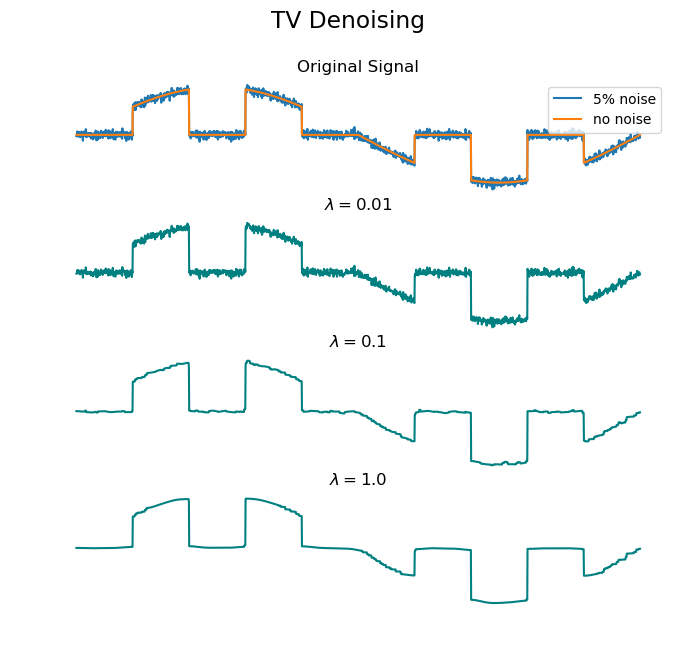

In [106]:
fig, axs = plt.subplots(4, 1, figsize=(8, 7))
fig.suptitle("TV Denoising")
axs[0].plot(b_, label='5% noise')
axs[0].plot(b, label='no noise')
axs[0].legend(loc='upper right', prop={'size': 10})
axs[0].axis('off')
axs[0].set_title('Original Signal', size=12)

for i, lam in enumerate([0.01, 0.1, 1.0]):
    %time hist, x = total_variation(b_, lam, 1.0, 1.0)
    axs[i+1].plot(x, 'teal', label=f'$\lambda = {lam}$')
    axs[i+1].set_title(f'$\lambda = {lam}$', size=12)
    axs[i+1].axis('off')

fig.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/tv_denoising.png", bbox_inches='tight', transparent=True)

CPU times: user 399 ms, sys: 1.91 ms, total: 401 ms
Wall time: 402 ms
CPU times: user 443 ms, sys: 3.38 ms, total: 446 ms
Wall time: 445 ms
CPU times: user 598 ms, sys: 2.7 ms, total: 601 ms
Wall time: 600 ms


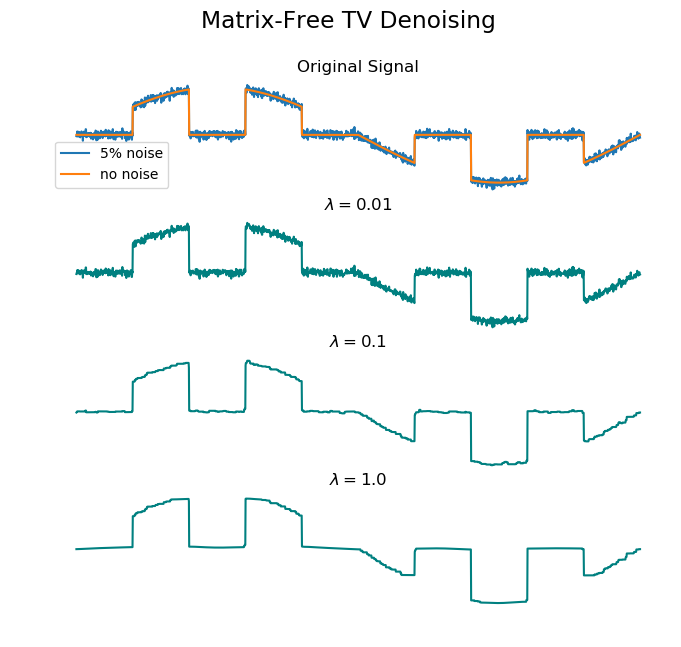

In [100]:
fig, axs = plt.subplots(4, 1, figsize=(8, 7))
fig.suptitle("Matrix-Free TV Denoising")
axs[0].plot(b_, label='5% noise')
axs[0].plot(b, label='no noise')
axs[0].legend(loc='best', prop={'size': 10})
axs[0].axis('off')
axs[0].set_title('Original Signal', size=12)

for i, lam in enumerate([0.01, 0.1, 1.0]):
    %time hist, x = matrix_free_tv(b_, lam, 1.0, 1.0)
    axs[i+1].plot(x, 'teal', label=f'$\lambda = {lam}$')
    axs[i+1].set_title(f'$\lambda = {lam}$', size=12)
    axs[i+1].axis('off')

fig.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/matrix_free_tv_denoising.png", bbox_inches='tight', transparent=True)

In [33]:
# benchmarking
import time

input_lengths = [100, 200, 500, 1000, 2000, 5000, 10000]

tv_wall = []
mf_tv_wall = []

for n in input_lengths:
    b = np.sin(np.linspace(0, np.pi * 2, n))
    for k in [range(i,i+100) for i in range(0,n,200)]:
        b[k] *= 0
    b_ = 0.05 * np.random.randn(n) + b
    
    start = time.time()
    _, x = total_variation(b_, 0.1, 1.0, 1.0)
    stop = time.time()
    print(stop-start)
    tv_wall.append(stop-start)
    
    start = time.time()
    _, x = matrix_free_tv(b_, 0.1, 1.0, 1.0)
    stop = time.time()
    print(stop-start)
    mf_tv_wall.append(stop-start)

0.06104302406311035
0.454179048538208
0.07294988632202148
0.43587708473205566
0.18088078498840332
0.42296886444091797
0.46865177154541016
0.40378499031066895
1.2173399925231934
0.4551389217376709
4.20118522644043
0.8297069072723389
11.639104843139648
1.8083178997039795


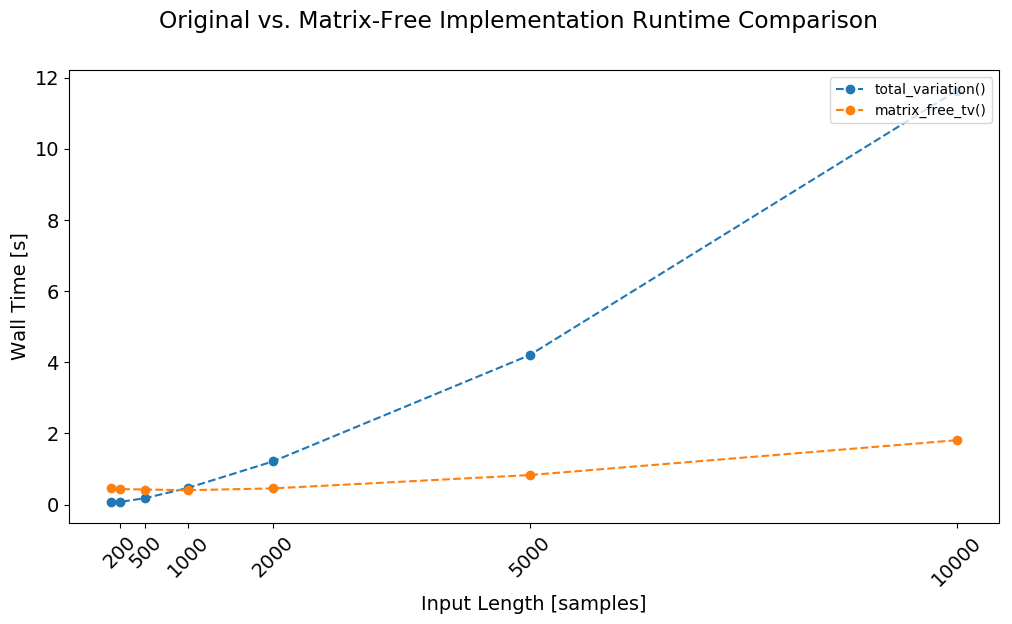

In [90]:
fig, ax = plt.subplots()

ax.plot(input_lengths, tv_wall, '--o', label="total_variation()")
ax.plot(input_lengths, mf_tv_wall, '--o', label="matrix_free_tv()")

fig.suptitle("Original vs. Matrix-Free Implementation Runtime Comparison")
ax.set_ylabel("Wall Time [s]")
ax.set_xlabel("Input Length [samples]")
ax.set_xticks(input_lengths[1:])
ax.set_xticklabels(input_lengths[1:], rotation=45)
ax.legend(loc='best', prop={'size': 10})

fig.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/runtime_benchmark.png", bbox_inches='tight', transparent=True)

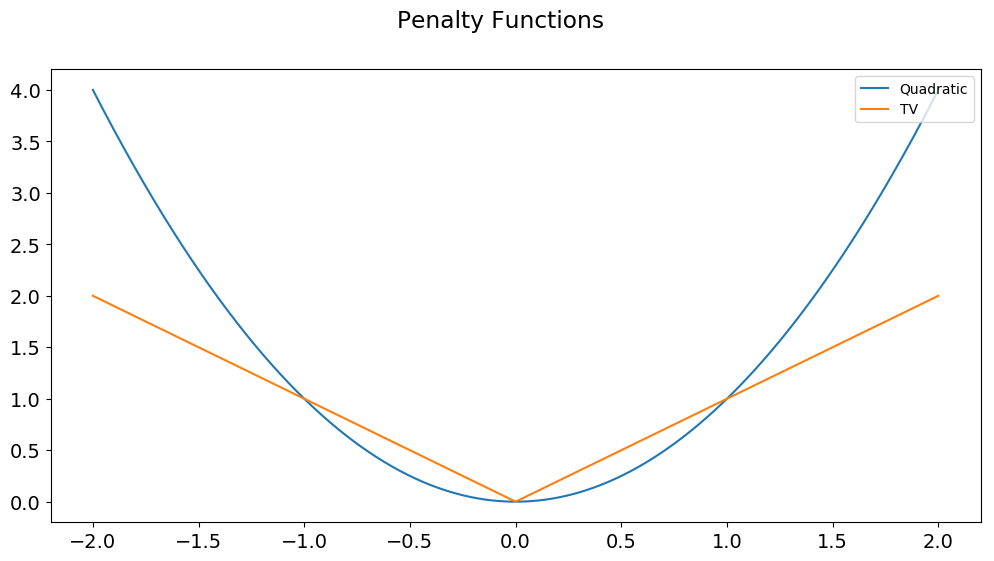

In [93]:
x = np.linspace(-2, 2, 1000)
fig, ax = plt.subplots()
fig.suptitle("Penalty Functions")
ax.plot(x, x**2, label="Quadratic")
ax.plot(x, np.abs(x), label="TV")
ax.legend(loc='best', prop={'size': 10})

fig.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/penalty_functions.png", bbox_inches='tight', transparent=True)